#Stock Market Prediction and Forecasting using Stacked LSTM


###Collecting Data

In [2]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd

csv_path = '/content/drive/MyDrive/Task 5 - LSTM StockPricePrediction/yahoo_stock.csv'  # Change this path to match your file location

# Step 3: Read the CSV file
df = pd.read_csv(csv_path)


In [4]:
#printing the first 5 elements
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [5]:
#Shape of the dataset
df.shape

(1825, 7)

In [6]:
df1 = df.reset_index()['Close']
df1.head()
#df1.shape

,Close
0,2086.590088
1,2089.139893
2,2088.870117
3,2088.870117
4,2090.110107


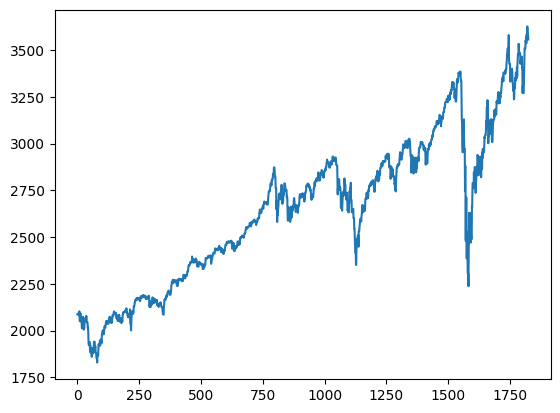

In [7]:
#Visualizing the Close Column
import matplotlib.pyplot as plt
plt.plot(df1)

In [8]:
##LSTM are sensitive to the scale of the data. SO we apply MinMax scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))
df1.shape


(1825, 1)

In [9]:
#After transfoming and scaling the close column displays as follows
print(df1)

[[0.14323386]
 [0.14465213]
 [0.14450208]
 ...
 [0.96711598]
 [0.97494769]
 [0.96141466]]


###Data Preprocessing

In [10]:
#TrainTest-Split
training_size=int(len(df1)*0.8)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [11]:
training_size,test_size

(1460, 365)

In [12]:
import numpy

#convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return numpy.array(dataX), numpy.array(dataY)

In [13]:
#reshape into X=t,t+1,t+2,t+3 and Y=t+4
timestep = 100
X_train, y_train = create_dataset(train_data, timestep)
X_test, y_test = create_dataset(test_data, timestep)

In [14]:
print(X_train.shape)

(1359, 100)


In [15]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

###Create Stack Lstm Model

In [16]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 243ms/step - loss: 0.0792 - val_loss: 0.0125
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step - loss: 0.0037 - val_loss: 0.0101
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 9.6241e-04 - val_loss: 0.0091
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 7.9506e-04 - val_loss: 0.0083
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 6.9418e-04 - val_loss: 0.0085
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 6.4389e-04 - val_loss: 0.0080
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 6.9429e-04 - val_loss: 0.0075
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - loss: 7.1112e-04 - val_loss: 0.0085
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 6.9023e-04 - val_loss: 0.0078
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 7.1474e-04 - val_loss: 0.0068
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - loss: 6.5532e-04 - val_loss: 0.0067
Epoc

###Prediction for the Training and Testing data

In [19]:
import tensorflow as tf
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [20]:
##Transform scaled ones into original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [21]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

2556.4192826848684

In [22]:
###Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

3103.4768699807555

###Visualization

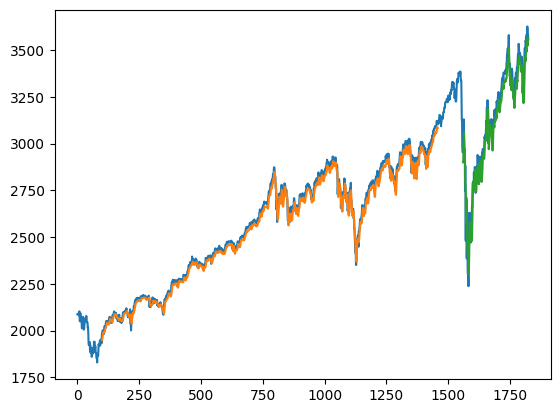

In [23]:
### Plotting
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [24]:
len(test_data)

365

###Predicting New Values

In [25]:
x_input=test_data[265:].reshape(1,-1)
x_input.shape

(1, 100)

In [26]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [27]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.93253976]
101
1 day input [0.85868529 0.85868529 0.85868529 0.86376914 0.86810216 0.85979774
 0.86572707 0.87220705 0.87220705 0.87220705 0.89118555 0.89804943
 0.91757845 0.92081572 0.93386477 0.93386477 0.93386477 0.92958185
 0.94423276 0.97437476 0.90441262 0.88878261 0.88878261 0.88878261
 0.88878261 0.83587445 0.87320828 0.83996263 0.84095273 0.84095273
 0.84095273 0.86463132 0.87445422 0.86571593 0.84987462 0.82899387
 0.82899387 0.82899387 0.80762927 0.82682464 0.78307738 0.78845618
 0.81730755 0.81730755 0.81730755 0.84686549 0.83789349 0.85320641
 0.86310726 0.84509659 0.84509659 0.84509659 0.87857038 0.85207726
 0.88459978 0.89983489 0.916694   0.916694   0.916694   0.94844343
 0.93604513 0.92310731 0.92014271 0.92040412 0.92040412 0.92040412
 0.88876034 0.89777131 0.89356621 0.90353931 0.91015834 0.91015834
 0.91015834 0.8743263  0.86860271 0.80205031 0.82378767 0.80145511
 0.80145511 0.80145511 0.82385991 0.85663271 0.89794921 0.93522193
 0.93466013 0.93466013 0.93466013

In [28]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)


###Visualizations

In [29]:
len(df1)

1825

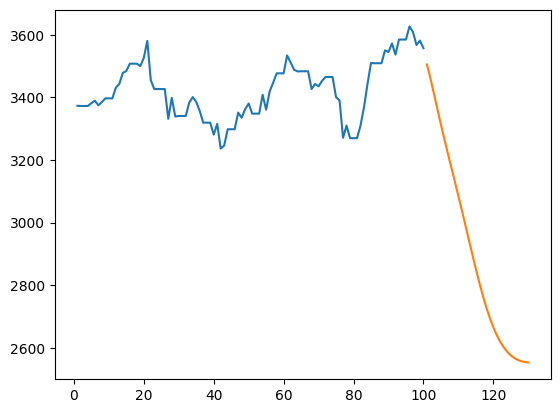

In [30]:
plt.plot(day_new,scaler.inverse_transform(df1[1725:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

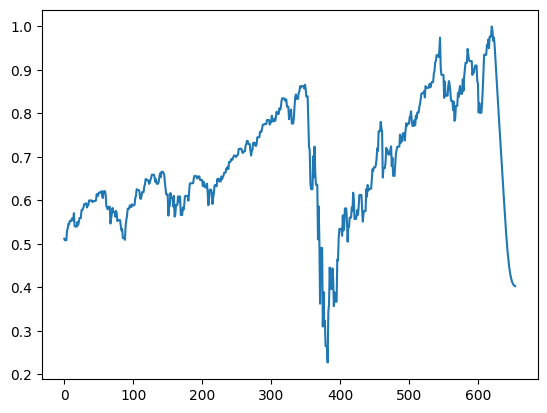

In [31]:

df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

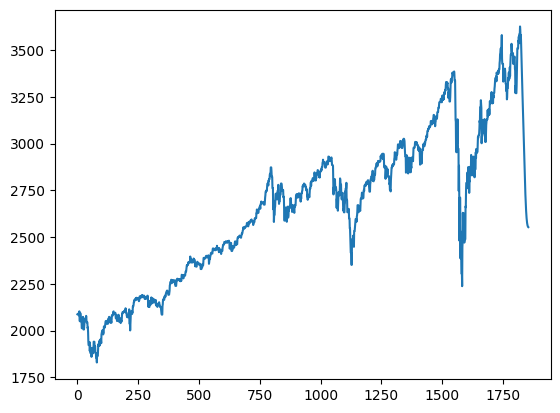

In [32]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)